In [27]:
import numpy as np
import os
import math
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import pandas
from tabulate import tabulate

In [114]:
# Fitness Function
def evalVRP(individual, num_locations, num_vehicles, locations, cost_vehicles):
    x,y=0,0
    depot=(0,0)
    total_distance, total_cost, total_time, total_ontime = 0, 0, 0, 0

    #total_time += total_distance
    distances=[]

    now_vehicles = num_vehicles - 1
    vehicle_route = [depot]

    newIndividual = individual + [num_locations]

    for i in range(num_locations + num_vehicles):
        if newIndividual[i] < num_locations:
            vehicle_route += [(locations[newIndividual[i]][0], locations[newIndividual[i]][1], locations[newIndividual[i]][2])]

        else:
            vehicle_route += [depot]
            vehicle_distance = 0
            timer = 0
            for j in range(0, len(vehicle_route)-2):
                tmp_distance = np.sqrt((vehicle_route[j][0]-vehicle_route[j+1][0])**2 + (vehicle_route[j][1]-vehicle_route[j+1][1])**2)
                vehicle_distance += tmp_distance
                timer += tmp_distance
                total_ontime -= (timer < vehicle_route[j+1][2])

            vehicle_distance += np.sqrt((vehicle_route[len(vehicle_route)-2][0]-0)**2 + (vehicle_route[len(vehicle_route)-2][1]-0)**2)
            total_cost += cost_vehicles[now_vehicles]*vehicle_distance
            total_time += vehicle_distance

            now_vehicles = newIndividual[i]%num_locations
            vehicle_route = [depot]

            distances.append(vehicle_distance)
    load_balancing = np.std(distances)  # Use standard deviation of distances as a penalty for imbalance among vehicles
    return total_ontime, total_cost, load_balancing, total_time

Xây dựng đầu ra mẫu

In [127]:
from functools import partial

_Test_arr = []
_load_balancing = []
_total_cost = []
_total_time = []
_total_ontime = []
_fitness = []

test_directory = './drive/MyDrive/Colab Notebooks/Test'
for item in sorted(os.listdir(test_directory)):
    item_path = os.path.join(test_directory, item)
    with open(item_path, 'r', encoding='utf-8') as file:
        _ = file.read()
    _ = _.split()

    # Pre Requisite Values
    cost_vehicles = []
    num_locations, num_vehicles = int(_[0]), int(_[1])
    for i in range(2,2+num_vehicles):
        cost_vehicles.append(int(_[i]))

    locations = []
    for i in range(2+num_vehicles, len(_) - 2, 3):
        locations.append((int(_[i]), int(_[i+1]), int(_[i+2])))

    depot=(0,0)

    # Genetic Algorithm Setup
    creator.create("FitnessMin", base.Fitness, weights=(-10.0,0.0001,0.00001,0.0000001)) #load_balancing,total_cost,total_time,-total_ontime
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(num_locations), num_locations) #mặc định xe cuối cùng đứng đầu individual
    # toolbox.register("indices", random.sample, range(num_locations + num_vehicles - 1 ), num_locations + num_vehicles - 1)

    toolbox.register("individual",tools.initIterate,creator.Individual,toolbox.indices)  #finish defining how to build an individual)
    toolbox.register("population",tools.initRepeat,list,toolbox.individual) #finish defining how to build an population)


    #Genetic Operators
    toolbox.register("evaluate", partial(evalVRP, num_locations=num_locations, num_vehicles=1, locations=locations, cost_vehicles= [max(cost_vehicles)] * len(cost_vehicles)))
    # toolbox.register("evaluate", partial(evalVRP, num_locations=num_locations, num_vehicles=num_vehicles, locations=locations, cost_vehicles= cost_vehicles))
    toolbox.register("mate",tools.cxOrdered) # lai ghép thứ tự

    toolbox.register("mutate",tools.mutShuffleIndexes,indpb=0.05) # Choose and configure a mutation method)
    toolbox.register("select", tools.selTournament, tournsize=3)


    pop = toolbox.population(100)  # Generate initial population
    hof = tools.HallOfFame(1)  # Hall of Fame to store the best individual

    for gen in range(10):
        algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 1, halloffame=hof, verbose=False)
        if item == '100_7_9.inp':
          _fitness.append(-10*(-(hof[0].fitness.values[0].astype(int))) + 0.0001*hof[0].fitness.values[1] + 0.00001*hof[0].fitness.values[2] + 0.0000001*hof[0].fitness.values[3])
    # print(-(hof[0].fitness.values[0].astype(int)))
    _Test_arr.append(item)
    _load_balancing.append(hof[0].fitness.values[2])
    _total_cost.append(hof[0].fitness.values[1])
    _total_time.append(hof[0].fitness.values[3])
    _total_ontime.append(str(-(hof[0].fitness.values[0].astype(int))) + "/" + str(num_locations))

    # plot_routes(hof[0], num_locations, num_vehicles, locations, "Route")
df = pandas.DataFrame({
    # 'Độ lệch tải': _load_balancing,
    'Testcase': _Test_arr,
    'Tổng chi phí': _total_cost,
    'Tổng thời gian': _total_time,
    'Giao đúng giờ':_total_ontime
})
print(tabulate(df, headers='keys', tablefmt='grid'))





+----+-------------+----------------+------------------+-----------------+
|    | Testcase    |   Tổng chi phí |   Tổng thời gian | Giao đúng giờ   |
+====+=============+================+==================+=================+
|  0 | 100_7_0.inp |       420497   |         21024.8  | 21/100          |
+----+-------------+----------------+------------------+-----------------+
|  1 | 100_7_1.inp |       380972   |         20051.1  | 21/100          |
+----+-------------+----------------+------------------+-----------------+
|  2 | 100_7_2.inp |       358306   |         19905.9  | 22/100          |
+----+-------------+----------------+------------------+-----------------+
|  3 | 100_7_3.inp |       353755   |         19653.1  | 22/100          |
+----+-------------+----------------+------------------+-----------------+
|  4 | 100_7_4.inp |       374162   |         19692.8  | 18/100          |
+----+-------------+----------------+------------------+-----------------+
|  5 | 100_7_5.inp |     

In [119]:
from functools import partial

Test_arr = []
load_balancing = []
total_cost = []
total_time = []
total_ontime = []

ontime_percent = []

fitness = []

test_directory = './drive/MyDrive/Colab Notebooks/Test'
for item in sorted(os.listdir(test_directory)):
    item_path = os.path.join(test_directory, item)
    with open(item_path, 'r', encoding='utf-8') as file:
        _ = file.read()
    _ = _.split()

    # Pre Requisite Values
    cost_vehicles = []
    num_locations, num_vehicles = int(_[0]), int(_[1])
    for i in range(2,2+num_vehicles):
        cost_vehicles.append(int(_[i]))

    locations = []
    for i in range(2+num_vehicles, len(_) - 2, 3):
        locations.append((int(_[i]), int(_[i+1]), int(_[i+2])))

    depot=(0,0)

    # Genetic Algorithm Setup
    creator.create("FitnessMin", base.Fitness, weights=(-10.0,0.0001,0.00001,0.0000001)) #load_balancing,total_cost,total_time,-total_ontime
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(num_locations+num_vehicles-1), num_locations+num_vehicles-1) #mặc định xe cuối cùng đứng đầu individual

    toolbox.register("individual",tools.initIterate,creator.Individual,toolbox.indices)  #finish defining how to build an individual)
    toolbox.register("population",tools.initRepeat,list,toolbox.individual) #finish defining how to build an population)


    #Genetic Operators
    toolbox.register("evaluate", partial(evalVRP, num_locations=num_locations, num_vehicles=num_vehicles, locations=locations, cost_vehicles=cost_vehicles))
    toolbox.register("mate",tools.cxPartialyMatched) # Lai ghép tương hợp bộ phận

    toolbox.register("mutate",tools.mutShuffleIndexes,indpb=0.05) # Chọn và điều chỉnh đột biến
    toolbox.register("select", tools.selTournament, tournsize=50)


    pop = toolbox.population(100)
    hof = tools.HallOfFame(1)  # Lưu cá thể tốt nhất


    for gen in range(150):
        algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 1, halloffame=hof, verbose=False)
        if item == '100_7_9.inp':
          fitness.append(-10*(-(hof[0].fitness.values[0].astype(int))) + 0.0001*hof[0].fitness.values[1] + 0.00001*hof[0].fitness.values[2] + 0.0000001*hof[0].fitness.values[3])
    # print(-(hof[0].fitness.values[0].astype(int)))
    Test_arr.append(item)
    load_balancing.append(hof[0].fitness.values[2])
    total_cost.append(hof[0].fitness.values[1])
    total_time.append(hof[0].fitness.values[3])
    total_ontime.append(str(-(hof[0].fitness.values[0].astype(int))) + "/" + str(num_locations))
    ontime_percent.append((-(hof[0].fitness.values[0].astype(int)))*100/num_locations)

    # plot_routes(hof[0], num_locations, num_vehicles, locations, "Route")
df = pandas.DataFrame({
    # 'Độ lệch tải': _load_balancing,
    'Testcase': Test_arr,
    'Tổng chi phí': total_cost,
    'Tổng thời gian': total_time,
    'Giao đúng giờ':total_ontime
})
print(tabulate(df, headers='keys', tablefmt='grid'))



+----+-------------+----------------+------------------+-----------------+
|    | Testcase    |   Tổng chi phí |   Tổng thời gian | Giao đúng giờ   |
+====+=============+================+==================+=================+
|  0 | 100_7_0.inp |       337262   |          23759.4 | 90/100          |
+----+-------------+----------------+------------------+-----------------+
|  1 | 100_7_1.inp |       240194   |          22931.2 | 93/100          |
+----+-------------+----------------+------------------+-----------------+
|  2 | 100_7_2.inp |       215090   |          18868.1 | 89/100          |
+----+-------------+----------------+------------------+-----------------+
|  3 | 100_7_3.inp |       215045   |          19656.3 | 93/100          |
+----+-------------+----------------+------------------+-----------------+
|  4 | 100_7_4.inp |       194948   |          20289.5 | 90/100          |
+----+-------------+----------------+------------------+-----------------+
|  5 | 100_7_5.inp |     

In [128]:
cost_saving = []
time_saving = []


for i in range(len(total_cost)):
    cost_saving.append((_total_cost[i] - total_cost[i])*100 / _total_cost[i])
    time_saving.append((_total_time[i] - total_time[i])*100 / _total_time[i])

df = pandas.DataFrame({
    # 'Độ lệch tải': _load_balancing,
    'Testcase': Test_arr,
    'Tiết kiệm chi phí (%)': cost_saving,
    'Tiết kiệm thời gian (%)': time_saving,
    'Giao đúng giờ (%)': ontime_percent
})
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+-------------+-------------------------+---------------------------+---------------------+
|    | Testcase    |   Tiết kiệm chi phí (%) |   Tiết kiệm thời gian (%) |   Giao đúng giờ (%) |
+====+=============+=========================+===========================+=====================+
|  0 | 100_7_0.inp |               19.7945   |               -13.0062    |             90      |
+----+-------------+-------------------------+---------------------------+---------------------+
|  1 | 100_7_1.inp |               36.9524   |               -14.3636    |             93      |
+----+-------------+-------------------------+---------------------------+---------------------+
|  2 | 100_7_2.inp |               39.9704   |                 5.2137    |             89      |
+----+-------------+-------------------------+---------------------------+---------------------+
|  3 | 100_7_3.inp |               39.2109   |                -0.0164328 |             93      |
+----+-------------+----------

Hàm fitness với lai ghép tương hợp bộ phận

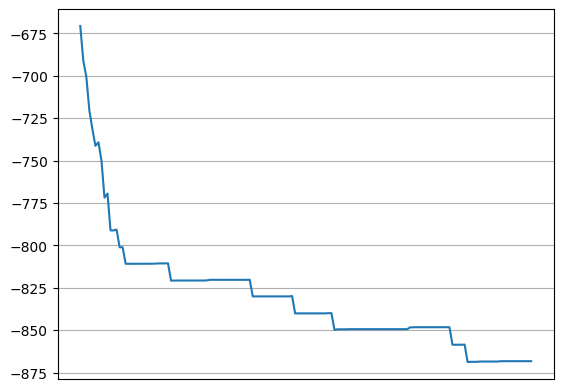

In [129]:
plt.plot(fitness)
# plt.ylabel('Giá trị thích nghi')
plt.grid(True)
plt.xticks([])
plt.show()